In [61]:
import calendar
import operator
from collections import Counter, namedtuple
from math import log
from typing import Tuple, Sequence
from itertools import cycle, islice

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import erfc
from numpy import square, sqrt
from numpy import square as sq
from numpy import pi as π
from numpy import exp as ℯ

In [62]:
mpl.rcParams["figure.figsize"] = 16, 9

In [63]:
#data = (pd.read_csv("/home/leyht/Downloads/untitled folder/{}.csv".format(k), header=0, index_col=0,
#                    parse_dates=True) for k in calendar.month_name[1:])
#data = pd.concat(data, keys=range(1,13), names=("month", "date"))
#data.to_hdf("data/futureswise.h5", "data", complevel=9, complib="bzip2")

In [64]:
data = pd.read_hdf("data/futureswise.h5")
expirations = pd.read_csv("data/expirations.csv", header=0, usecols=range(1,10),
                          parse_dates=list(range(9)), index_col=0)
termstructure = pd.read_csv("data/8_m_settle.csv", usecols=range(1,10), parse_dates=True,
                            header=0, index_col=0, na_values=0)
symbols = pd.read_csv("data/8_m_symbols.csv", usecols=range(1,10), parse_dates=True,
                      header=0, index_col=0)

In [65]:
for year in data:
    yint = int(year)
    # This internally raises an exception but it's just some localization problem.
    # The resulting data seems correct.
    data[year].index = pd.MultiIndex(levels=[data[year].index.levels[0],
                                             data[year].index.levels[1].map(lambda x: pd.Timestamp(yint, x.month, x.day))],
                                     labels=data[year].index.labels)

Exception ignored in: 'pandas._libs.tslib._localize_tso'
Traceback (most recent call last):
  File "pandas/_libs/tslib.pyx", line 4332, in pandas._libs.tslib._get_dst_info (pandas/_libs/tslib.c:72500)
  File "pandas/_libs/tslib.pyx", line 1425, in pandas._libs.tslib._get_utcoffset (pandas/_libs/tslib.c:27137)
AttributeError: 'Int64Index' object has no attribute 'utcoffset'
Exception ignored in: 'pandas._libs.tslib._localize_tso'
Traceback (most recent call last):
  File "pandas/_libs/tslib.pyx", line 4332, in pandas._libs.tslib._get_dst_info (pandas/_libs/tslib.c:72500)
  File "pandas/_libs/tslib.pyx", line 1425, in pandas._libs.tslib._get_utcoffset (pandas/_libs/tslib.c:27137)
AttributeError: 'Int64Index' object has no attribute 'utcoffset'
Exception ignored in: 'pandas._libs.tslib._localize_tso'
Traceback (most recent call last):
  File "pandas/_libs/tslib.pyx", line 4332, in pandas._libs.tslib._get_dst_info (pandas/_libs/tslib.c:72500)
  File "pandas/_libs/tslib.pyx", line 1425, in 

In [66]:
# Concatenate the columns to get a large series of spread prices.
spreads = pd.concat((data[year].dropna() for year in data))

In [67]:
date_mask = spreads.index.droplevel(0).isin(termstructure.index)
filtered_spreads = spreads.where(date_mask).dropna()

In [68]:
# These are the spread prices loaded from file.
filtered_spreads[:,"2017-04-27"]

month
6    -0.200
7     0.450
8    -0.300
9     0.375
10    0.100
11    0.200
12   -0.800
dtype: float64

In [69]:
# These are spread prices calculated from the term structure.
# Why are these different from each other?
termstructure.loc["2017-04-27"].aggregate(lambda x: [-x[i] + 2*x[i+1] - x[i+2] for i in range(6)])

[-0.27000000000000135,
 0.46000000000000085,
 -0.3100000000000005,
 0.41999999999999815,
 0.050000000000004263,
 0.24999999999999645]

# Problem

Doesn't seem like I can fit the new data of spread prices to the term structures. 

Better to get the spread prices in their necessary representation directly from the old proven term structure data.

In [70]:
assert expirations.shape == termstructure.shape
assert expirations.index.equals(termstructure.index)

In [71]:
long_prices = termstructure.apply(lambda x: [np.nan] + [2*x[i] - x[i-1] - x[i+1] for i in range(1, len(x) - 1)] + [np.nan],
                                  axis=1, reduce=False)
long_prices.dropna(axis=(0,1), how="all", inplace=True)

In [72]:
threshold_date = "2006-10-23"

In [73]:
long_prices_thresh = long_prices[threshold_date:]
day_diff = pd.Series(long_prices_thresh.index[1:]- long_prices_thresh.index[:-1])
count_day_diff = Counter(day_diff)

In [74]:
# There's not much difference between two index dates lying next to each other.
# Further modifications aren't necessary.
count_day_diff

Counter({Timedelta('1 days 00:00:00'): 2081,
         Timedelta('2 days 00:00:00'): 24,
         Timedelta('3 days 00:00:00'): 478,
         Timedelta('4 days 00:00:00'): 70,
         Timedelta('5 days 00:00:00'): 2})

In [75]:
termstructure_thresh = termstructure[threshold_date:]
assert len(termstructure_thresh) == len(long_prices_thresh)

In [76]:
days_into_future = 1

In [77]:
y = pd.concat((long_prices_thresh.iloc[days_into_future:][column]
               for column in long_prices_thresh))
x = termstructure_thresh.iloc[:-days_into_future]
for i in range(len(long_prices_thresh.columns) - 1):
    x = x.append(termstructure_thresh.iloc[:-days_into_future])
assert len(y) == len(x)
x = x.where((np.tile(y.notnull().values, (len(x.columns),1)).T)).dropna(axis=0, how="all")
y = y.where(y.notnull()).dropna()
assert len(y) == len(x)

In [78]:
#x.to_hdf("data/futureswise_mapping.h5", "x", complevel=9, complib="bzip2")
#y.to_hdf("data/futureswise_mapping.h5", "y", complevel=9, complib="bzip2")

# Not we've prepared the data

Cool. So $x$ is the data mapping to target $y$. But now I'd like to split in into test and validation set similar to the other representation.

In [79]:
split_between_years = np.append(0, y.index.get_loc("2017-05-11") + 1)
splits = split_between_years
split_between_years

array([    0,  2655,  5310,  7965, 10593, 13047, 15193])

In [80]:
def split_indices(a: int, b: int, val_split=0.15, test_split=0.15):
    half = int((b - a) / 2)
    val_len = int(half * val_split)
    test_len = int(half * test_split)
    val1 = a + half - val_len - test_len
    test1 = a + half - test_len
    data = a + half
    val2 = b - val_len - test_len
    test2 = b - test_len
    return a, val1, test1, data, val2, test2, b

In [81]:
def splitted_dataset(dataset, splits: Sequence):
    indices = pd.DataFrame((split_indices(splits[i], splits[i+1]) for i in range(len(splits) - 1)),
                           columns=("data1", "val1", "test1", "data2", "val2", "test2", "end"))
    d1, v1, t1, d2, v2, t2 = ([dataset.iloc[a:b] for a, b in zip(indices.iloc[:,i], indices.iloc[:,i+1])]
                              for i in range(len(indices.columns) - 1))
    return pd.concat(d1 + d2), pd.concat(v1 + v2), pd.concat(t1 + t2)

In [82]:
indices = pd.DataFrame((split_indices(splits[i], splits[i+1]) for i in range(len(splits) - 1)),
                       columns=("data1", "val1", "test1", "data2", "val2", "test2", "end"))
indices

,data1,val1,test1,data2,val2,test2,end
0,0,929,1128,1327,2257,2456,2655
1,2655,3584,3783,3982,4912,5111,5310
2,5310,6239,6438,6637,7567,7766,7965
3,7965,8885,9082,9279,10199,10396,10593
4,10593,11452,11636,11820,12679,12863,13047
5,13047,13800,13960,14120,14873,15033,15193


In [83]:
xdata, xval, xtest = splitted_dataset(x, split_between_years)
assert len(xdata) + len(xval) + len(xtest) == len(x)
ydata, yval, ytest = splitted_dataset(y, split_between_years)
assert len(ydata) + len(yval) + len(ytest) == len(y)

# Incorporate information about futures month into data

It seems a bit difficult to train a large network which has distinguish different spread prices by month by itself. So my idea would be to train twelve different networks (because there are twelve months obviously) directly with the different months' prices.

Now I have just to think about how I get these spreads out of the data. Maybe with the `8_m_symbols.csv`?

In [84]:
symbols_to_month = {"F":"January",
                    "G":"February",
                    "H":"March",
                    "J":"April",
                    "K":"May",
                    "M":"June",
                    "N":"July",
                    "Q":"August",
                    "U":"September",
                    "V":"October",
                    "X":"November",
                    "Z":"December"}

In [85]:
def year_month_repr(self):
    return str((self.year, self.month))
YearMonth = namedtuple("YearMonth", ["year", "month"])
YearMonth.__repr__ = year_month_repr
symbols_short = symbols.applymap(lambda x: YearMonth(int(x[-3:-1]), operator.indexOf(calendar.month_name, symbols_to_month[x[0]])) if isinstance(x, str) else x)

In [86]:
count_ym = Counter(symbols_short.values.reshape(symbols_short.size))

In [87]:
def filter_by_yearmonth(dataframe, year, month):
    return dataframe.applymap(lambda x: True if isinstance(x, YearMonth) and x.year == year and x.month == month else False)

In [88]:
mask_dict = {key:filter_by_yearmonth(symbols_short, key.year, key.month) for key in count_ym
             if isinstance(key, YearMonth)}

In [89]:
long_prices = termstructure.apply(lambda x: [np.nan] + [2*x[i] - x[i-1] - x[i+1] for i in range(1, len(x) - 1)] + [np.nan],
                                  axis=1, reduce=False)
assert long_prices.index.equals(symbols_short.index)
assert long_prices.shape == symbols_short.shape

## Some explanation in between

Up to now I prepared masks for all spread prices in `mask_dict`. With this one can select spreads with the `where` method.

Next I need all the x-y-mappings from the term structure to the spread prices of the next day with appropricate shape. There will be such a mapping for each month.

In [90]:
test_16_05 = long_prices.where(mask_dict[YearMonth(16,5)]).dropna(how="all", axis=(0,1))

In [91]:
y_16_05 = pd.concat((test_16_05.iloc[days_into_future:][col] for col in test_16_05)).dropna().sort_index()
x_16_05 = termstructure.loc[test_16_05.index].iloc[:-days_into_future]

In [92]:
c_16_05 = Counter(y_16_05.index - x_16_05.index)
for key in c_16_05:
    assert key.days <= 5

The code above was just playing around and testing. Now let's make a function out of this.

In [93]:
def x_y_mapping(long_prices, termstructure, mask, days_into_future=1, yearmonth=None):
    prices = long_prices.where(mask).dropna(how="all", axis=(0,1))
    try:
        if yearmonth:
            assert not prices.empty, "There are no spread prices for year {} and month {}.".format(yearmonth.year,
                                                                                                   yearmonth.month)
        else:
            assert not prices.empty
    except AssertionError as e:
        print(e)
        return None
    y = pd.concat((prices.iloc[days_into_future:][column] for column in prices)).dropna().sort_index()
    x = termstructure.loc[prices.index].iloc[:-days_into_future]
    assert len(x) == len(y)
    counter = Counter(y.index - x.index)
    for key in counter:
        try:
            if yearmonth:
                assert key.days <= 5, str(counter) + "\n" + "At year {} and month {}".format(yearmonth.year, yearmonth.month)
            else:
                assert key.days <= 5, str(counter)
        except AssertionError as e:
            print(e)
    return x, y

In [94]:
mapping_dict = {key:x_y_mapping(long_prices, termstructure, mask_dict[key], yearmonth=key) for key in mask_dict}

There are no spread prices for year 4 and month 5.
There are no spread prices for year 4 and month 6.
There are no spread prices for year 4 and month 8.
There are no spread prices for year 4 and month 11.
There are no spread prices for year 5 and month 2.
There are no spread prices for year 4 and month 9.
There are no spread prices for year 5 and month 5.
There are no spread prices for year 5 and month 1.
There are no spread prices for year 5 and month 8.
There are no spread prices for year 5 and month 3.
There are no spread prices for year 5 and month 11.
There are no spread prices for year 5 and month 6.
There are no spread prices for year 6 and month 2.
There are no spread prices for year 5 and month 10.
There are no spread prices for year 6 and month 5.
There are no spread prices for year 5 and month 12.
There are no spread prices for year 6 and month 8.
There are no spread prices for year 6 and month 3.
There are no spread prices for year 6 and month 6.
There are no spread prices 

In [95]:
sorted_keys = [item[0] for item in mapping_dict.items() if item[1]]
sorted_keys.sort()
years = list({key[0] for key in sorted_keys})
years.sort()
[str("%02d" % year) for year in years]

['04', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17']

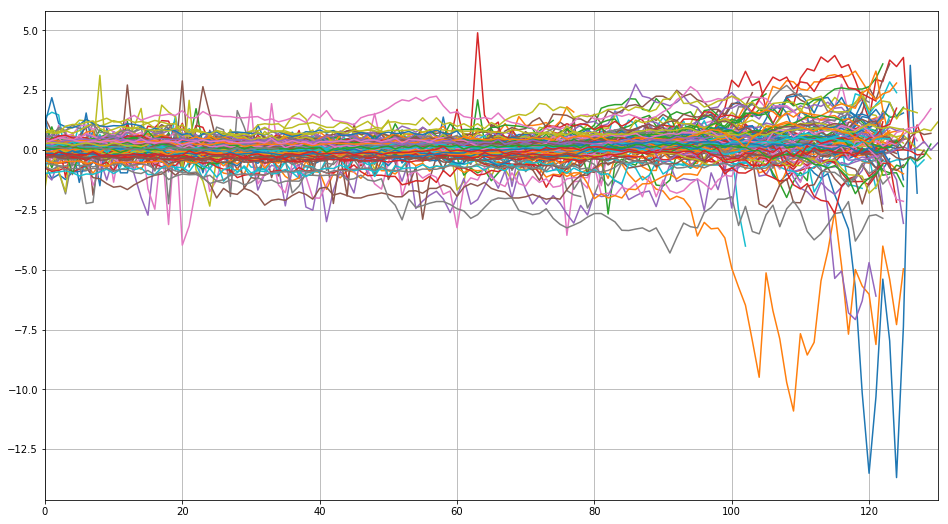

In [96]:
for key in sorted_keys:
    x, y = mapping_dict[key]
    plt.plot(np.arange(len(y)), y.values)
plt.xlim(0,130)
plt.grid()
plt.show()

In [97]:
y = pd.concat((mapping_dict[key][1] for key in sorted_keys), keys=sorted_keys, names=["year", "month"])
x = pd.concat((mapping_dict[key][0] for key in sorted_keys), keys=sorted_keys, names=["year", "month"])
assert len(x) == len(y)

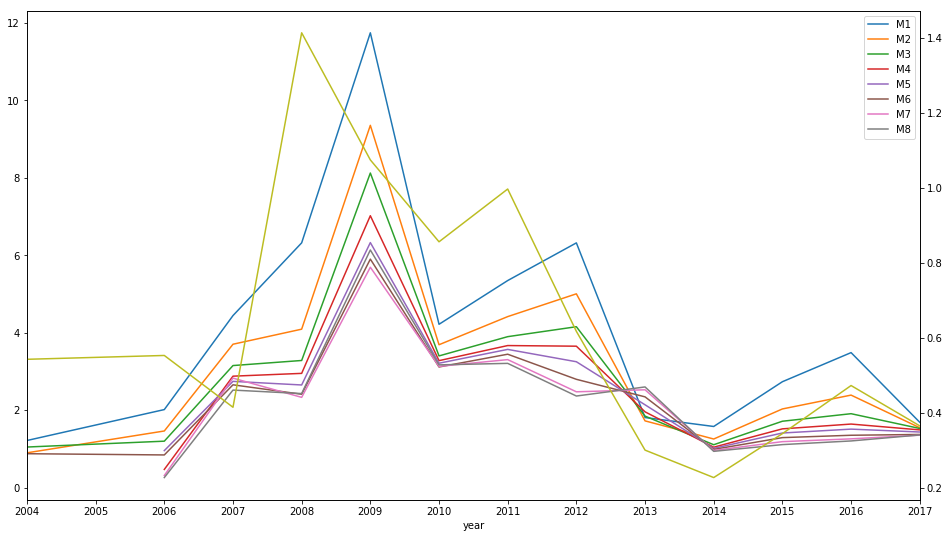

In [98]:
x.groupby("year").std().plot()
y.groupby("year").std().plot(secondary_y=True)
plt.xticks(np.arange(4,18), np.arange(2004,2018))
plt.show()

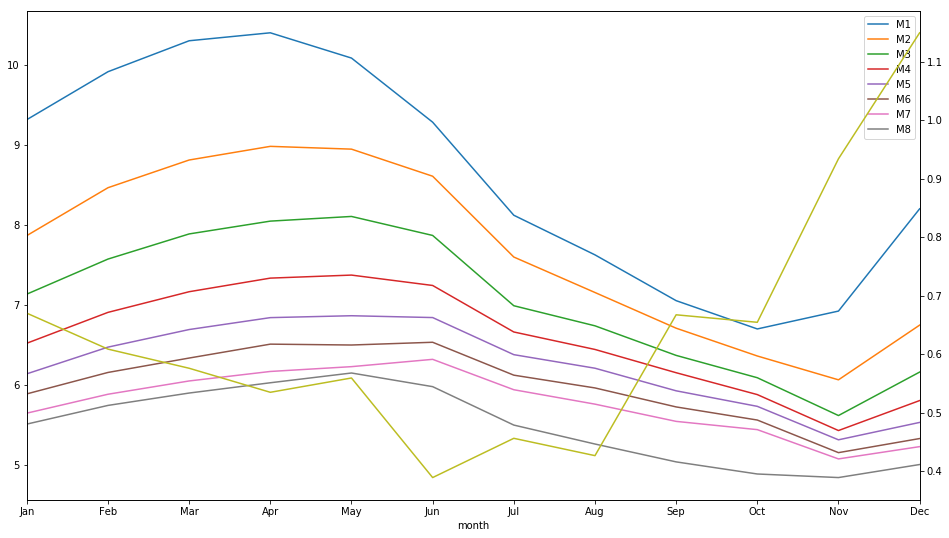

In [99]:
x.groupby("month").std().plot()
y.groupby("month").std().plot(secondary_y=True)
plt.xticks(np.arange(1,13), calendar.month_abbr[1:])
plt.show()

In [100]:
for month_nr in range(1,13):
    assert len(y.loc(axis=0)[:,month_nr]) == len(x.loc(axis=0)[:,month_nr])
    print(calendar.month_name[month_nr], len(y.loc(axis=0)[:,month_nr]))

January 1281
February 1239
March 1238
April 1329
May 1289
June 1279
July 1328
August 1224
September 1236
October 1281
November 1256
December 1213


In [101]:
#x.to_hdf("data/futures_per_year_and_month.h5", "x", complevel=9, complib="bzip2")
#y.to_hdf("data/futures_per_year_and_month.h5", "y", complevel=9, complib="bzip2")

# I'll just start here anew

Idea: Work on the ordering of the data. At the moment there is this mapping:

* M1 ... M8 -> Spread

Better would be something like this:

* Jan ... Dec -> Spread
* Just map the second level of the row multiindex to column headers

In [102]:
x = pd.read_hdf("data/futures_per_year_and_month.h5", "x")
y = pd.read_hdf("data/futures_per_year_and_month.h5", "y")

In [103]:
x.loc(axis=0)[:, :, "2017-05-10"]

M1     M2     M3    M4    M5     M6    M7     M8
year month date                                                           
17   6     2017-05-10  11.55  12.47  13.68  14.4  15.3  15.73  16.1  16.33
     7     2017-05-10  11.55  12.47  13.68  14.4  15.3  15.73  16.1  16.33
     8     2017-05-10  11.55  12.47  13.68  14.4  15.3  15.73  16.1  16.33
     9     2017-05-10  11.55  12.47  13.68  14.4  15.3  15.73  16.1  16.33
     10    2017-05-10  11.55  12.47  13.68  14.4  15.3  15.73  16.1  16.33
     11    2017-05-10  11.55  12.47  13.68  14.4  15.3  15.73  16.1  16.33

In [104]:
y.loc(axis=0)[:, :, "2017-05-5"]

year  month  date      
17    6      2017-05-05   -0.10
      7      2017-05-05    0.43
      8      2017-05-05   -0.32
      9      2017-05-05    0.43
      10     2017-05-05    0.05
      11     2017-05-05    0.24
dtype: float64

In [105]:
symbols.loc["2017-05-5"]

M1    K (May 17)
M2    M (Jun 17)
M3    N (Jul 17)
M4    Q (Aug 17)
M5    U (Sep 17)
M6    V (Oct 17)
M7    X (Nov 17)
M8    Z (Dec 17)
Name: 2017-05-05 00:00:00, dtype: object

In [106]:
symbols_short.loc["2017-01-20"]

M1    (17, 2)
M2    (17, 3)
M3    (17, 4)
M4    (17, 5)
M5    (17, 6)
M6    (17, 7)
M7    (17, 8)
M8    (17, 9)
Name: 2017-01-20 00:00:00, dtype: object

In [107]:
x.apply(lambda x: [i for i in 
                   islice(cycle(range(1, 13)), x.name[1] + 10, x.name[1] + 18)], axis=1)

M1  M2  M3  M4  M5  M6  M7  M8
year month date                                      
4    7     2004-05-24   6   7   8   9  10  11  12   1
           2004-05-25   6   7   8   9  10  11  12   1
           2004-05-26   6   7   8   9  10  11  12   1
           2004-05-27   6   7   8   9  10  11  12   1
           2004-05-28   6   7   8   9  10  11  12   1
           2004-06-01   6   7   8   9  10  11  12   1
           2004-06-02   6   7   8   9  10  11  12   1
           2004-06-03   6   7   8   9  10  11  12   1
           2004-06-04   6   7   8   9  10  11  12   1
           2004-06-07   6   7   8   9  10  11  12   1
           2004-06-08   6   7   8   9  10  11  12   1
           2004-06-09   6   7   8   9  10  11  12   1
           2004-06-10   6   7   8   9  10  11  12   1
           2004-06-14   6   7   8   9  10  11  12   1
     10    2004-08-23   9  10  11  12   1   2   3   4
           2004-08-24   9  10  11  12   1   2   3   4
           2004-08-25   9  10  11  12   1   2   3   4
           2004-08-26   9  10  11  12   1   2   3   4
           2004-08-27   9  10  11  12   1   2   3   4
           2004-08-30   9  10  11  12   1   2   3   4
           2004-08-31   9  10  11  12   1   2   3   4
           2004-09-01   9  10  11  12   1   2   3   4
           2004-09-02   9  10  11  12   1   2   3   4
           2004-09-03   9  10  11  12   1   2   3   4
           2004-09-07   9  10  11  12   1   2   3   4
           2004-09-08   9  10  11  12   1   2   3   4
           2004-09-09   9  10  11  12   1   2   3   4
           2004-09-10   9  10  11  12   1   2   3   4
           2004-09-13   9  10  11  12   1   2   3   4
6    1     2005-11-21  12   1   2   3   4   5   6   7
...                    ..  ..  ..  ..  ..  ..  ..  ..
17   10    2017-04-21   9  10  11  12   1   2   3   4
           2017-04-24   9  10  11  12   1   2   3   4
           2017-04-25   9  10  11  12   1   2   3   4
           2017-04-26   9  10  11  12   1   2   3   4
           2017-04-27   9  10  11  12   1   2   3   4
           2017-04-28   9  10  11  12   1   2   3   4
           2017-05-01   9  10  11  12   1   2   3   4
           2017-05-02   9  10  11  12   1   2   3   4
           2017-05-03   9  10  11  12   1   2   3   4
           2017-05-04   9  10  11  12   1   2   3   4
           2017-05-05   9  10  11  12   1   2   3   4
           2017-05-08   9  10  11  12   1   2   3   4
           2017-05-09   9  10  11  12   1   2   3   4
           2017-05-10   9  10  11  12   1   2   3   4
     11    2017-04-19  10  11  12   1   2   3   4   5
           2017-04-20  10  11  12   1   2   3   4   5
           2017-04-21  10  11  12   1   2   3   4   5
           2017-04-24  10  11  12   1   2   3   4   5
           2017-04-25  10  11  12   1   2   3   4   5
           2017-04-26  10  11  12   1   2   3   4   5
           2017-04-27  10  11  12   1   2   3   4   5
           2017-04-28  10  11  12   1   2   3   4   5
           2017-05-01  10  11  12   1   2   3   4   5
           2017-05-02  10  11  12   1   2   3   4   5
           2017-05-03  10  11  12   1   2   3   4   5
           2017-05-04  10  11  12   1   2   3   4   5
           2017-05-05  10  11  12   1   2   3   4   5
           2017-05-08  10  11  12   1   2   3   4   5
           2017-05-09  10  11  12   1   2   3   4   5
           2017-05-10  10  11  12   1   2   3   4   5

[15193 rows x 8 columns]

In [108]:
symbols_month = symbols_short.applymap(lambda x: x if isinstance(x, float) else x[1]).interpolate(axis=1).apply(
                    lambda x: [i for i in islice(cycle(range(1, 13)), int(x[3]) + 8, int(x[3]) + 16)], axis=1)

In [109]:
test_x = x.loc(axis=0)[16,1,:].iloc[0]
test_x.index = symbols_month.loc[test_x.name[2]]
symbols_month.loc[test_x.name[2]]

M1     7
M2     8
M3     9
M4    10
M5    11
M6    12
M7     1
M8     2
Name: 2015-06-17 00:00:00, dtype: int64

In [110]:
def month_to_header(x):
    global symbols_month
    x.index = symbols_month.loc[x.name[2]]
    return pd.Series({k:x.get(k, default=np.nan) for k in range(1, 13)})
x_yearly = x.apply(month_to_header, axis=1)

In [111]:
# Some tests
assert x.index.equals(x_yearly.index)
for xi, xyi in zip(x.isnull().sum(axis=1), x_yearly.isnull().sum(axis=1)):
    assert xi == xyi - 4  # Because 12 month minus 8 months is 4 months

In [112]:
# More tests
for month in range(1, 13):
    assert len(x.loc(axis=0)[:, month]) == len(y.loc(axis=0)[:, month])
    assert len(x_yearly.loc(axis=0)[:, month]) == len(y.loc(axis=0)[:, month])
#x_yearly.to_hdf("data/futures_per_year_and_month.h5", "x_yearly", complevel=9, complib="bzip2")

In [113]:
print(pd.concat([x_yearly]*3, axis=1).loc(axis=0)[16,1].iloc[:,6:18].to_string())

               7      8      9      10     11     12     1      2      3      4      5      6 
date                                                                                          
2015-06-17  15.65  16.40  17.01  17.54  17.91  18.05  18.75  19.10    NaN    NaN    NaN    NaN
2015-06-18  14.99  15.90  16.60  17.23  17.63  17.80  18.46  18.80    NaN    NaN    NaN    NaN
2015-06-19  15.45  16.35  16.95  17.50  17.82  18.00  18.61  18.90    NaN    NaN    NaN    NaN
2015-06-22  14.55  15.55  16.34  16.90  17.34  17.56  18.18  18.55    NaN    NaN    NaN    NaN
2015-06-23  14.10  15.25  16.10  16.70  17.18  17.42  18.05  18.38    NaN    NaN    NaN    NaN
2015-06-24  14.58  15.62  16.37  16.95  17.33  17.52  18.15  18.42    NaN    NaN    NaN    NaN
2015-06-25  14.65  15.62  16.33  16.95  17.30  17.55  18.18  18.44    NaN    NaN    NaN    NaN
2015-06-26  14.55  15.46  16.20  16.75  17.15  17.35  18.05  18.33    NaN    NaN    NaN    NaN
2015-06-29  17.40  17.42  17.68  17.93  18.17  18.

# Yearly structure has too many NaNs

When looking at future for month x make it so that for the inputs the rows are in the following order:

$x-1, x, x+1, \dots, x+6$ therefore having inputs with eight rows.

In [136]:
pd.concat([x_yearly.loc(axis=0)[:, 5]] * 3, axis=1).iloc[:, 5+10:5+18]

4       5      6      7       8      9      10  \
year month date                                                            
7    5     2006-11-20  13.90  14.560  15.45    NaN     NaN    NaN    NaN   
           2006-12-27  14.44  15.060  15.31    NaN  15.755    NaN    NaN   
           2006-12-28  14.50  15.130  15.47    NaN  15.850    NaN    NaN   
           2006-12-29  14.53  15.250  15.48    NaN  15.950    NaN    NaN   
           2007-01-03  14.53  15.250  15.48    NaN  15.920    NaN    NaN   
           2007-01-04  14.30  15.150  15.45    NaN  15.950    NaN    NaN   
           2007-01-05  14.39  15.200  15.50    NaN  15.950    NaN    NaN   
           2007-01-08  14.44  15.000  15.46    NaN  15.900    NaN    NaN   
           2007-01-09  14.34  14.900  15.35    NaN  15.940    NaN    NaN   
           2007-01-10  14.39  14.800  15.30    NaN  15.900    NaN    NaN   
           2007-01-11  14.00  14.710  15.04    NaN  15.710    NaN    NaN   
           2007-01-12  13.80  14.410  14.88    NaN  15.440    NaN    NaN   
           2007-01-16  13.72  14.400  14.86    NaN  15.450    NaN    NaN   
           2007-01-17  13.57  14.360  14.71    NaN  15.300    NaN    NaN   
           2007-01-18  13.44  14.010  14.64    NaN  15.080    NaN    NaN   
           2007-01-19  13.41  13.970  14.59    NaN  15.040    NaN    NaN   
           2007-01-22  13.39  14.050  14.54  14.73  15.070    NaN    NaN   
           2007-01-23  13.40  13.910  14.40  14.68  14.900    NaN    NaN   
           2007-01-24  13.22  13.810  14.27  14.41  14.760    NaN    NaN   
           2007-01-25  13.51  13.930  14.11  14.43  14.770    NaN    NaN   
           2007-01-26  13.55  13.910  14.20  14.40  14.800    NaN    NaN   
           2007-01-29  13.45  13.890  14.21  14.40  14.800    NaN    NaN   
           2007-01-30  13.35  13.750  14.14  14.41  14.750    NaN    NaN   
           2007-01-31  13.15  13.700  14.06  14.33  14.660    NaN    NaN   
           2007-02-01  13.08  13.650  14.00  14.31  14.600    NaN    NaN   
           2007-02-02  13.05  13.710  14.05  14.26  14.680    NaN    NaN   
           2007-02-05  13.02  13.760  14.05  14.40  14.750    NaN    NaN   
           2007-02-06  12.83  13.395  13.89  14.32  14.600    NaN    NaN   
           2007-02-07  12.80  13.500  13.82  14.10  14.550    NaN    NaN   
           2007-02-08  12.86  13.520  13.85  14.13  14.600    NaN    NaN   
...                      ...     ...    ...    ...     ...    ...    ...   
17   5     2017-03-06  14.40  15.350  15.99  16.65  16.900  17.46  17.72   
           2017-03-07  14.45  15.350  16.05  16.65  16.950  17.55  17.75   
           2017-03-08  14.45  15.320  15.98  16.60  16.880  17.50  17.78   
           2017-03-09  14.45  15.250  15.95  16.55  16.850  17.55  17.77   
           2017-03-10  14.20  15.100  15.79  16.40  16.800  17.40  17.67   
           2017-03-13  13.85  14.870  15.65  16.35  16.700  17.29  17.60   
           2017-03-14  14.08  15.010  15.75  16.50  16.850  17.48  17.77   
           2017-03-15  13.71  14.710  15.54  16.26  16.600  17.25  17.55   
           2017-03-16  13.25  14.330  15.24  16.01  16.350  17.05  17.39   
           2017-03-17  13.25  14.230  15.10  15.85  16.300  16.90  17.30   
           2017-03-20  13.18  14.140  14.99  15.79  16.200  16.90  17.30   
           2017-03-21  13.77  14.550  15.35  16.13  16.510  17.19  17.52   
           2017-03-22  13.92  14.580  15.27  16.00  16.450  17.25  17.61   
           2017-03-23  14.30  14.770  15.50  16.20  16.700  17.40  17.75   
           2017-03-24  13.95  14.350  15.12  15.91  16.360  17.09  17.45   
           2017-03-27  13.60  14.050  14.73  15.53  16.020  16.82  17.22   
           2017-03-28  12.92  13.560  14.37  15.22  15.740  16.51  16.93   
           2017-03-29  12.94  13.500  14.23  15.07  15.600  16.35  16.80   
           2017-03-30  12.82  13.350  14.17  15.05  15.490  16.28  16.75   
           2017-03-31  13.28  13.580  14.25  15.00  15.500  16.26  16.70  

In [135]:
x_yearly.loc(axis=0)[:, 5].count()

1      622
2      838
3     1073
4     1289
5     1289
6     1289
7     1039
8      872
9      569
10     364
11     416
12     412
dtype: int64

## How to easily extract spread prices from x

In [114]:
testblah = pd.concat([x_yearly] * 3, axis=1).iloc[:, 11:25]

In [115]:
x_spreads_yearly = testblah.apply(lambda x: [np.nan] + [2*x.iloc[i] - x.iloc[i-1] - x.iloc[i+1]
                                                        for i in range(1, len(x) - 1)] + [np.nan],
                                  axis=1).iloc[:, 1:13]

In [116]:
x.apply(lambda x: [np.nan] + [2*x[i] - x[i-1] - x[i+1] for i in range(1, len(x) - 1)] + [np.nan], axis=1).iloc[:, 1:7]

M2    M3    M4    M5    M6    M7
year month date                                          
4    7     2004-05-24 -1.13   NaN   NaN   NaN   NaN   NaN
           2004-05-25 -0.61   NaN   NaN   NaN   NaN   NaN
           2004-05-26 -1.19   NaN   NaN   NaN   NaN   NaN
           2004-05-27 -1.02   NaN   NaN   NaN   NaN   NaN
           2004-05-28 -1.23   NaN   NaN   NaN   NaN   NaN
           2004-06-01 -0.92   NaN   NaN   NaN   NaN   NaN
           2004-06-02 -0.89   NaN   NaN   NaN   NaN   NaN
           2004-06-03 -0.86   NaN   NaN   NaN   NaN   NaN
           2004-06-04 -0.51   NaN   NaN   NaN   NaN   NaN
           2004-06-07 -0.18   NaN   NaN   NaN   NaN   NaN
           2004-06-08  0.15   NaN   NaN   NaN   NaN   NaN
           2004-06-09  0.61   NaN   NaN   NaN   NaN   NaN
           2004-06-10 -0.40   NaN   NaN   NaN   NaN   NaN
           2004-06-14 -0.40   NaN   NaN   NaN   NaN   NaN
     10    2004-08-23 -0.51   NaN   NaN   NaN   NaN   NaN
           2004-08-24 -0.29   NaN   NaN   NaN   NaN   NaN
           2004-08-25 -0.61   NaN   NaN   NaN   NaN   NaN
           2004-08-26 -0.56   NaN   NaN   NaN   NaN   NaN
           2004-08-27 -0.16   NaN   NaN   NaN   NaN   NaN
           2004-08-30 -0.24   NaN   NaN   NaN   NaN   NaN
           2004-08-31  0.24   NaN   NaN   NaN   NaN   NaN
           2004-09-01  0.25   NaN   NaN   NaN   NaN   NaN
           2004-09-02 -0.26   NaN   NaN   NaN   NaN   NaN
           2004-09-03 -0.10   NaN   NaN   NaN   NaN   NaN
           2004-09-07  0.10   NaN   NaN   NaN   NaN   NaN
           2004-09-08  0.46   NaN   NaN   NaN   NaN   NaN
           2004-09-09  0.45   NaN   NaN   NaN   NaN   NaN
           2004-09-10  0.33   NaN   NaN   NaN   NaN   NaN
           2004-09-13  0.66   NaN   NaN   NaN   NaN   NaN
6    1     2005-11-21  0.51   NaN   NaN   NaN   NaN   NaN
...                     ...   ...   ...   ...   ...   ...
17   10    2017-04-21 -0.62  0.21 -0.43  0.37  0.05  0.31
           2017-04-24 -0.27  0.38 -0.38  0.46  0.07  0.29
           2017-04-25 -0.20  0.30 -0.30  0.35  0.05  0.27
           2017-04-26 -0.02  0.36 -0.30  0.42  0.02  0.20
           2017-04-27 -0.27  0.46 -0.31  0.42  0.05  0.25
           2017-04-28 -0.01  0.37 -0.28  0.35  0.02  0.30
           2017-05-01 -0.20  0.38 -0.23  0.42 -0.03  0.25
           2017-05-02  0.09  0.48 -0.40  0.50  0.00  0.18
           2017-05-03 -0.06  0.42 -0.26  0.30  0.10  0.20
           2017-05-04  0.01  0.42 -0.33  0.44 -0.05  0.30
           2017-05-05 -0.10  0.43 -0.32  0.43  0.05  0.24
           2017-05-08 -0.10  0.57 -0.22  0.40  0.08  0.17
           2017-05-09 -0.11  0.51 -0.12  0.33  0.09  0.19
           2017-05-10 -0.29  0.49 -0.18  0.47  0.06  0.14
     11    2017-04-19 -0.64  0.28 -0.43  0.34  0.10  0.22
           2017-04-20 -0.63  0.26 -0.40  0.39  0.10  0.27
           2017-04-21 -0.62  0.21 -0.43  0.37  0.05  0.31
           2017-04-24 -0.27  0.38 -0.38  0.46  0.07  0.29
           2017-04-25 -0.20  0.30 -0.30  0.35  0.05  0.27
           2017-04-26 -0.02  0.36 -0.30  0.42  0.02  0.20
           2017-04-27 -0.27  0.46 -0.31  0.42  0.05  0.25
           2017-04-28 -0.01  0.37 -0.28  0.35  0.02  0.30
           2017-05-01 -0.20  0.38 -0.23  0.42 -0.03  0.25
           2017-05-02  0.09  0.48 -0.40  0.50  0.00  0.18
           2017-05-03 -0.06  0.42 -0.26  0.30  0.10  0.20
           2017-05-04  0.01  0.42 -0.33  0.44 -0.05  0.30
           2017-05-05 -0.10  0.43 -0.32  0.43  0.05  0.24
           2017-05-08 -0.10  0.57 -0.22  0.40  0.08  0.17
           2017-05-09 -0.11  0.51 -0.12  0.33  0.09  0.19
           2017-05-10 -0.29  0.49 -0.18  0.47  0.06  0.14

[15193 rows x 6 columns]

# Working on some ideas for alternative spread representations

In [142]:
spread_ts = termstructure.apply(lambda x: [np.nan] + [2*x[i] - x[i-1] - x[i+1] for i in range(1, len(x) - 1)] + [np.nan], axis=1).dropna(how="all", axis=(0, 1))

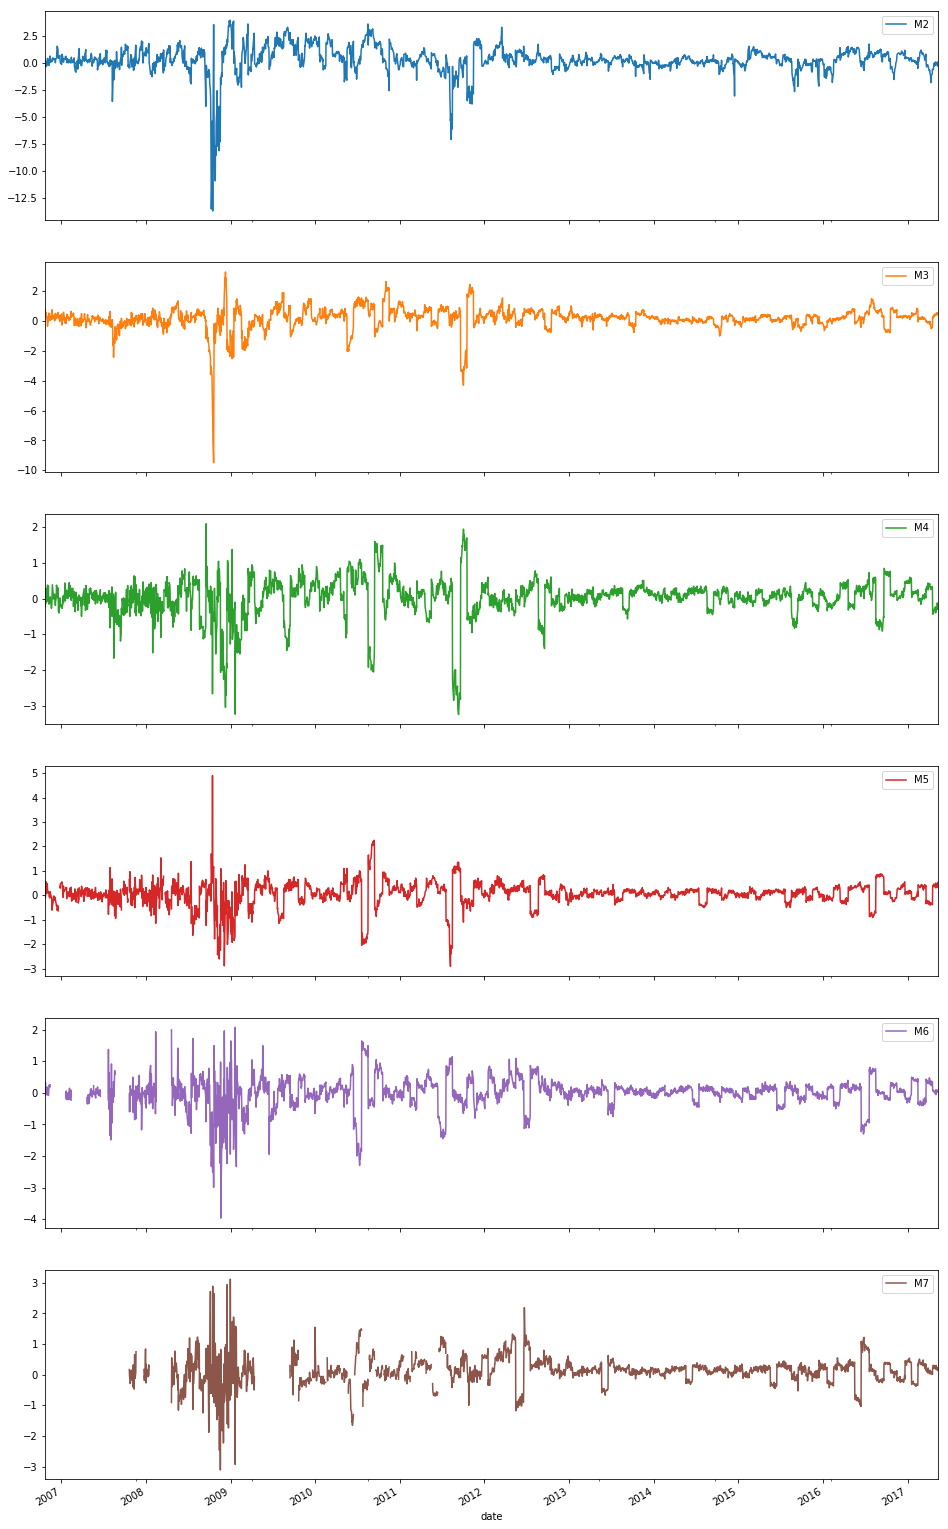

In [186]:
spread_ts.loc["2006-10-23":].plot(subplots=True, figsize=(16, 30))
plt.show()

In [212]:
# Naive prediction when using term structure
spread_per_column = pd.concat((spread_ts.loc["2006-10-23":, column] for column in spread_ts), axis=1)
for column in spread_per_column:
    dropped = spread_per_column.loc[:, column].dropna()
    print(column, np.mean(np.square(dropped.iloc[:-1].values - dropped.iloc[1:].values)))

M2 0.383355706215
M3 0.11088653484
M4 0.0885584180791
M5 0.10773685312
M6 0.152070680522
M7 0.179882983683


In [213]:
spread_per_column.describe()

,M2,M3,M4,M5,M6,M7
count,2656.000000,2656.000000,2656.000000,2629.000000,2455.000000,2146.000000
mean,0.277579,0.178172,0.014480,0.054692,0.006312,0.129515
std,1.289689,0.740439,0.543991,0.497983,0.481377,0.456469
min,-13.680000,-9.490000,-3.250000,-2.910000,-3.970000,-3.110000
25%,-0.102500,-0.040000,-0.150000,-0.110000,-0.150000,-0.050000
50%,0.290000,0.230000,0.090000,0.100000,0.050000,0.150000
75%,0.800000,0.480000,0.260000,0.300000,0.200000,0.300000
max,3.950000,3.290000,2.100000,4.900000,2.080000,3.120000


# Some descriptive statistics about spreads

In [117]:
y_desc = y.describe()
y_mean = y_desc["mean"]
y_std = y_desc["std"]
y_var = np.square(y_std)
y_desc

count    15193.000000
mean         0.110257
std          0.746659
min        -13.680000
25%         -0.100000
50%          0.130000
75%          0.360000
max          4.900000
dtype: float64

## Calculating some SELU stuff

First some test with zero mean and unit variance; then use the values one line above.

From <https://arxiv.org/abs/1706.02515>, p. 11

In [118]:
def μ_tilde(μ, ω, ν, τ, λ, α):
    t1 = (-(α + μ * ω) *
             erfc((μ * ω) / (sqrt(2) * sqrt(ν * τ))))
    t2 = (α * ℯ(μ * ω + (ν * τ) / 2) *
             erfc((μ * ω + ν * τ) / (sqrt(2) * sqrt(ν * τ))))
    t3 = (sqrt(2 / π) * sqrt(ν * τ) *
             ℯ(-(sq(μ) * sq(ω)) / (2 * ν * τ)))
    t4 = 2 * μ * ω
    return (λ / 2) * (t1 + t2 + t3 + t4)

def xi_tilde(μ, ω, ν, τ, λ, α):
    t1 = (sq(μ * ω) + ν * τ) * (erfc((μ * ω) / (sqrt(2) * sqrt(ν * τ))) + 1)
    t2 = sq(α) * (-2 * ℯ(μ * ω + (ν * τ) / 2) * erfc((μ * ω + ν * τ) / (sqrt(2) * sqrt(ν * τ))) +
                  ℯ(2 * (μ * ω + ν * τ)) * erfc((μ * ω + 2 * ν * τ) / (sqrt(2) * sqrt(ν * τ))) +
                  erfc((μ * ω) / (sqrt(2) * sqrt(ν * τ))))
    t3 = sqrt(2 * π) * (μ * ω) * sqrt(ν * τ) * ℯ(-(sq(μ * ω)) / (2 * ν * τ))
    return (sq(λ) / 2) * (t1 + t2 + t3)

def ν_tilde(μ, ω, ν, τ, λ, α):
    return xi_tilde(μ, ω, ν, τ, λ, α) - sq(μ_tilde(μ, ω, ν, τ, λ, α))

In [119]:
assert np.isclose(mu_tilde(0, 0, 1, 1, 1.0507, 1.67326), 0, atol=1e-06), "This should be close to 0 but isn't."
assert np.isclose(ny_tilde(0, 0, 1, 1, 1.0507, 1.67326), 1, atol=1e-06), "This should be close to 1 but isn't."

NameError: name 'mu_tilde' is not defined

In [ ]:
print(mu_tilde(0, 0, 1, 1, 1.0507, 1.67326))
print(ny_tilde(0, 0, 1, 1, 1.0507, 1.67326))  # Shit. 1.55 != 1

In [150]:
((y - y.mean()) / y.std()).describe()

count    1.519300e+04
mean    -2.806066e-17
std      1.000000e+00
min     -1.846929e+01
25%     -2.815977e-01
50%      2.644133e-02
75%      3.344803e-01
max      6.414903e+00
dtype: float64

# Plotting the spreads per month

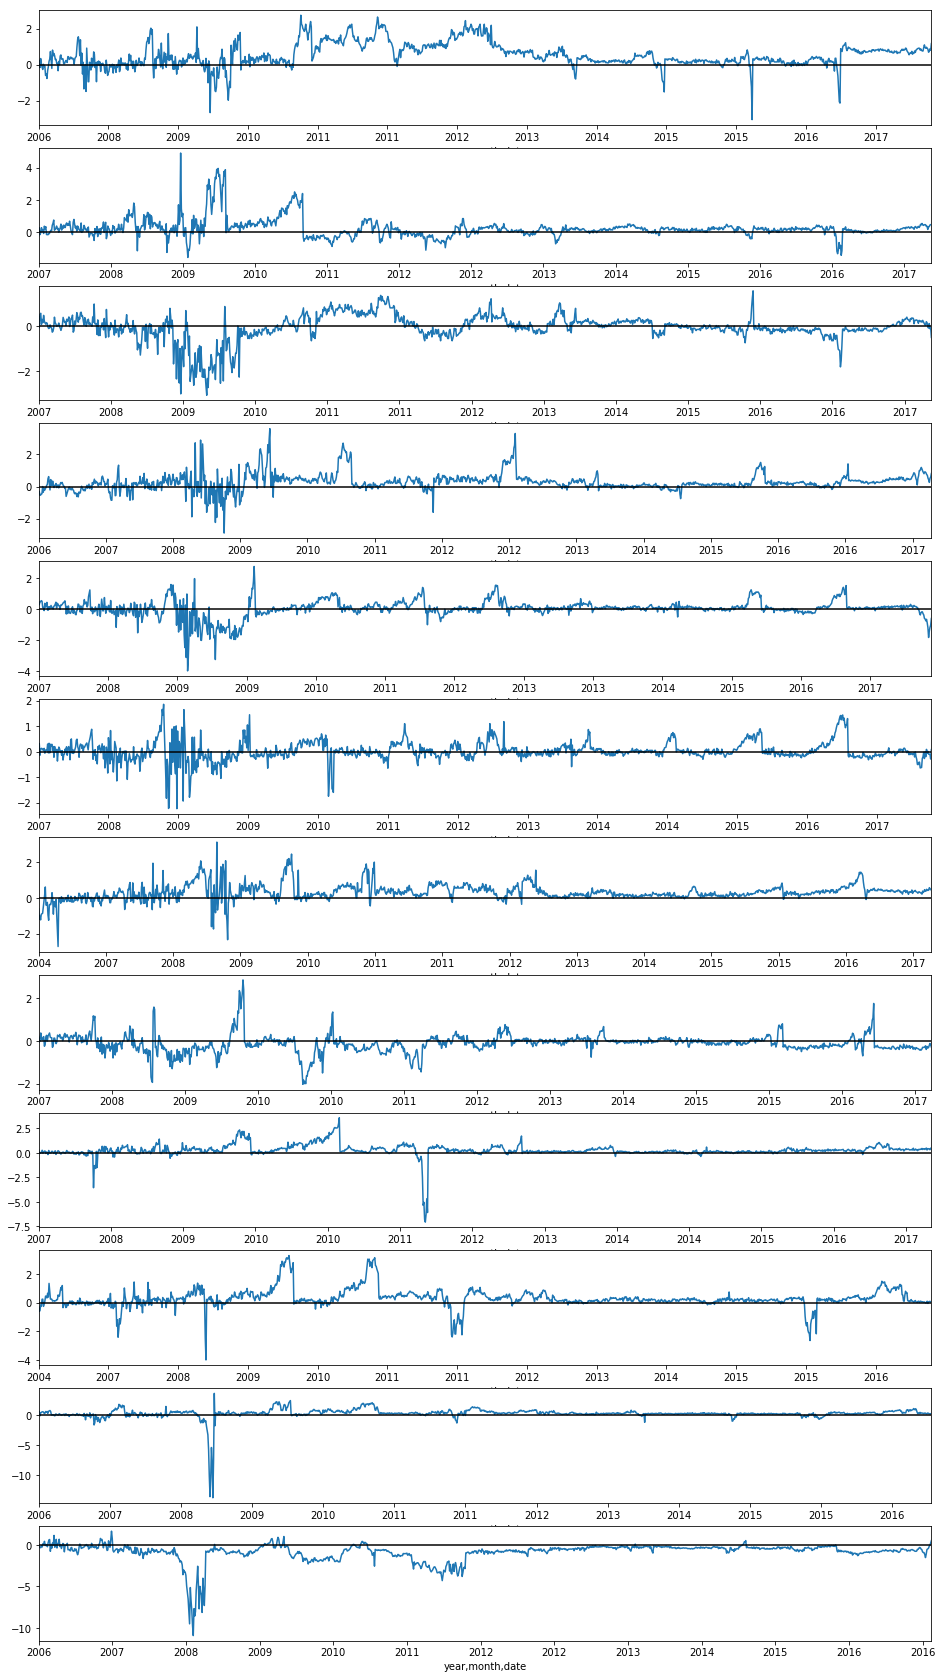

In [183]:
fig = plt.figure(figsize=(16, 30))
for month in range(1, 13):
    ax = fig.add_subplot(12, 1, month)
    y_m = y.loc(axis=0)[:, month]
    y_m.plot(ax=ax)
    plt.axhline(0, color="black")
    plt.xticks(np.arange(0, len(y_m), 100), (y_m.index.droplevel([1, 2]) + 2000)[::100])
plt.show()

In [180]:
(y_m.index.droplevel([1, 2]) + 2000)[::10]

Int64Index([2006, 2006, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007,
            ...
            2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2017, 2017],
           dtype='int64', name='year', length=126)